In [3]:
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

labels = [
    "0 h",
    "8 h",
    "24 h",
]

color1 = "#f7a863"
color2 = "#d25743"
color3 = "#2b3744"
sublabels = [
    "s- ring - fibril",
    "s+ ring - fibril",
    "s+ ring + fibril",
]
sublabel_colors = [color1, color2, color3]
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/post_bioRxiv_Figs/Morphology-aging"


# For first time calculation only
folder_data = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/all_SPT_in_condensates/Reconstruction_20ms-FUS488_10kframes-aging"
folders = [
    "Reconstruction_40ms-AF647dye-FUS488-FUSpart_as_0h_control",
    "aging_8h",
    "aging_24h",
]
subfolders = [
    "step1_before_ring_complete",
    "step2_ring_completed",
    "step3_fibril",
]

## Calculate and save stats

In [74]:
def count_condensates(path):
    lst_tif = [f for f in os.listdir(path) if f.endswith(".tif")]
    lst_rep_title = list(set([s.split("FOV")[0] for s in lst_tif]))
    lst_N_per_rep = []
    for rep_title in lst_rep_title:
        lst_tif_per_rep = [f for f in lst_tif if f.startswith(rep_title)]
        lst_N_per_rep.append(len(lst_tif_per_rep))
    return lst_rep_title, lst_N_per_rep


os.chdir(folder_data)
lst_rows = []
for label, folder in zip(labels, folders):  # loop each condition
    for sublabel, subfolder in zip(sublabels, subfolders):
        lst_rep_title, lst_N_per_rep = count_condensates(join(folder, subfolder))
        for rep_title, N_per_rep in zip(lst_rep_title, lst_N_per_rep):
            lst_rows.append([label, sublabel, rep_title, N_per_rep])
df_raw = pd.DataFrame(
    lst_rows,
    columns=["label", "sublabel", "rep_title", "N_per_rep"],
    dtype=object,
)
df_raw = df_raw.astype(
    {
        "label": str,
        "sublabel": str,
        "rep_title": str,
        "N_per_rep": int,
    }
)
df_raw.to_csv(
    join(folder_save, "N_condensate_per_condition_per_replicate.csv"),
    index=False,
)

In [75]:
lst_rows = []
for label in labels:
    df_current_label = df_raw[df_raw["label"] == label]
    current_rep_titles = df_current_label["rep_title"].unique()
    for rep_title in current_rep_titles:
        df_current_rep = df_current_label[df_current_label["rep_title"] == rep_title]
        N_sum = df_current_rep["N_per_rep"].sum()
        percents = df_current_rep["N_per_rep"] / N_sum
        current_sublabels = df_current_rep["sublabel"]
        for sublabel, percent in zip(current_sublabels, percents):
            lst_rows.append([label, rep_title, sublabel, percent])

df_percent = pd.DataFrame(
    lst_rows,
    columns=["label", "rep_title", "sublabel", "percent"],
    dtype=object,
)
df_percent = df_percent.astype(
    {
        "label": str,
        "sublabel": str,
        "rep_title": str,
        "percent": float,
    }
)
df_percent.to_csv(
    join(folder_save, "F_per_condition_per_replicate.csv"),
    index=False,
)

In [76]:
lst_rows = []
for label in labels:
    df_current_label = df_percent[df_percent["label"] == label]
    current_rep_titles = df_current_label["rep_title"].unique()
    for sublabel in sublabels:
        df_current = df_current_label[df_current_label["sublabel"] == sublabel]
        F_mean = df_current['percent'].mean()
        F_sem = df_current['percent'].sem()
        lst_rows.append([label, sublabel, F_mean, F_sem])

df_stats = pd.DataFrame(
    lst_rows,
    columns=["label", "sublabel", "F_mean", "F_sem"],
    dtype=object,
)
df_stats = df_stats.astype(
    {
        "label": str,
        "sublabel": str,
        "F_mean": float,
        "F_sem": float,
    }
)
df_stats.to_csv(
    join(folder_save, "F_per_condition_stats.csv"),
    index=False,
)

# Stacked bar plot

s- ring - fibril :
label: ['0 h', '8 h', '24 h']
fraction: [1.         0.13262441 0.28099126]
sem: [0.         0.05048814 0.07982721]
#f7a863
[0. 0. 0.]
s+ ring - fibril :
label: ['0 h', '8 h', '24 h']
fraction: [0.         0.83865699 0.28730441]
sem: [0.         0.04902084 0.05445145]
#d25743
[1.         0.13262441 0.28099126]
s+ ring + fibril :
label: ['0 h', '8 h', '24 h']
fraction: [0.         0.02871859 0.43170433]
sem: [0.         0.00386365 0.03547773]
#2b3744
[1.         0.9712814  0.56829567]


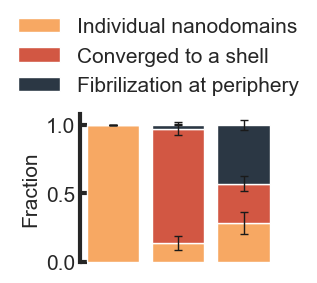

In [27]:
fontsize = 15
fig = plt.figure(figsize=(3, 3))
x = [1, 2, 3]
df_fractions = pd.read_csv(join(folder_save, "F_per_condition_stats.csv"))
df_fractions = df_fractions.astype(
    {
        "label": str,
        "sublabel": str,
        "F_mean": float,
        "F_sem": float,
    }
)

bottom = np.zeros(len(x))
for i in range(len(sublabels)):
    df_current = df_fractions[df_fractions["sublabel"] == sublabels[i]]
    plt.bar(
        x=x,
        height=df_current["F_mean"],
        yerr=df_current["F_sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        label=labels,
        bottom=bottom,
        color=sublabel_colors[i],
    )
    print(sublabels[i], ":")
    print("label:", labels)
    print("fraction:", df_current["F_mean"].to_numpy())
    print("sem:", df_current["F_sem"].to_numpy())
    print(sublabel_colors[i])
    print(bottom)
    bottom += df_current["F_mean"].to_numpy(float)
plt.ylim(0, 1.08)
plt.ylabel("Fraction", size=fontsize)
plt.xticks([])
plt.yticks([0, 0.5, 1])
plt.legend(
    [
        "Individual nanodomains",
        "Converged to a shell",
        "Fibrilization at periphery",
    ],
    frameon=False,
    fontsize=fontsize,
    loc="lower center",
    bbox_to_anchor=(0.4, 1),
    ncol=1,
)
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[["right", "top", "bottom"]].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
canvas_width = 0.5
plt.xlim(1 - canvas_width, 3 + canvas_width)
plt.xlabel("")
plt.tight_layout()
plt.savefig(
    join(folder_save, "Fracs_compare_left_0h_mid_8h_right_24h.png"),
    format="png",
    bbox_inches="tight",
    dpi=300,
)